### 제품 review 데이터의 감성 분석 

---
##### 1. 데이터 
`amazon_uk_shoes_products_dataset_2021_12.csv` 데이터 사용
##### 2. 데이터 전처리
- 데이터 정리 (노이즈 제거, 결측값 처리 등).
- 텍스트 토큰화 및 불용어 제거.
- 텍스트 정규화 (스테밍 또는 표제어 추출).
##### 3. 모델 구현
- 수업에서 활용한 모델 VADER을 적용
##### 4. 모델 학습 및 튜닝
- 데이터셋을 학습 및 테스트 세트로 분할.
- 모델 학습 및 하이퍼파라미터 튜닝 (예: 그리드 서치 또는 랜덤 서치 사용).
- 교차 검증과 같은 기술을 사용하여 견고성 보장.
##### 5. 모델 평가
- 정확도, 정밀도, 재현율, F1 점수 및 ROC-AUC와 같은 지표를 사용하여 모델 평가.
- 오버피팅과 언더피팅을 논의하고 이를 해결하는 방법 학습.
##### 6. 시각화 및 보고
- Matplotlib 또는 Seaborn과 같은 라이브러리를 사용하여 결과 시각화.
- 혼동 행렬 및 ROC 곡선 생성.

---

### 0. 환경 구성
감정분석에 사용될 패키지 및 라이브러리를 설치하고 import 합니다. 

In [1]:
# 필요한 라이브러리 설치
%pip install nltk
%pip install pandas # pandas 설치
%pip install matplotlib # 시각화 목적 matplotlib 설치
%pip install seaborn

# nltk 라이브러리 가져오기
import nltk as nltk

# 필요한 nltk 데이터 다운로드
nltk.download('vader_lexicon')  # 감성 분석을 위한 VADER 사전 다운로드
nltk.download('punkt')          # 텍스트 토큰화를 위한 punkt 데이터 다운로드
nltk.download('stopwords')      # 불용어 리스트 다운로드
nltk.download('wordnet')        # 워드넷 데이터 다운로드

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# 필요한 라이브러리 임포트
import time
from nltk.corpus import stopwords  # 불용어 처리
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # nltk의 VADER 감정 분석기를 가져옴
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 matplotlib
import seaborn as sns  # 데이터 시각화를 위한 seaborn
import re  #정규 표현식을 위한 re
from nltk.tokenize import word_tokenize  #텍스트 토큰화를 위한 word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer  # 형태소 분석을 위한 Lemmatizer와 Stemmer
import warnings  # 경고 무시를 위한 warnings
from pandas import * #데이터프레임 pandas

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

### 1. 데이터 전처리

홀수 데이터에 해당하는 `amazon_uk_shoes_products_dataset_2021_12.csv` 를 pandas로 읽어와서 데이터 프레임으로 저장하고 확인합니다.

In [3]:
row_data = read_csv("./amazon_uk_shoes_products_dataset_2021_12.csv")

row_data.head()

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
4,https://www.amazon.co.uk/dp/B08SW434MG,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0,True,Reviewed in Italy on 2 April 2021,2 people found this helpful,232dee43-849e-5d06-ba05-efb3f4814714,24/12/2021 02:26:25


In [4]:
#데이터프레임 info()를 통하여 데이터프레임 각 열의 정보를 확인
row_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB


데이터의 정보를 확인합니다. 총 11개의 열이 있고, 다음과 같은 정보를 담고 있습니다.

In [5]:
#샘플 데이터 출력
print("url : ", row_data.iloc[0, 0])
print("product_name : ", row_data.iloc[0, 1])
print("reviewer_name : ", row_data.iloc[0, 2])
print("review_title : ", row_data.iloc[0, 3])
print("review_text : ", row_data.iloc[0, 4])
print("review_rating : ", row_data.iloc[0, 5])
print("verified_purchase : ", row_data.iloc[0, 6])
print("review_date : ", row_data.iloc[0, 7])
print("helpful_count : ", row_data.iloc[0, 8])
print("uniq_id : ", row_data.iloc[0, 9])
print("scraped_at : ", row_data.iloc[0, 10])

url :  https://www.amazon.co.uk/dp/B07SBX32T5
product_name :  Klasified Women's Transparent Clear Sneaker Shoe, White, 5.5 UK
reviewer_name :  Jocelyn McSayles
review_title :  Love em
review_text :  Love these. Was looking for converses and these were half the price and so unique— I’ve never seen clear shoes like these; they fit great. The plastic takes a little getting used to but the style is so worth it.
review_rating :  5.0
verified_purchase :  True
review_date :  Reviewed in the United States on 2 June 2020
helpful_count :  2 people found this helpful
uniq_id :  36eae4e5-2894-5279-a0b7-d2b330e2b814
scraped_at :  24/12/2021 02:26:25


어떤 내용으로 들어있는지 확인하기 위해 샘플 데이터 하나 골라 출력하여 확인합니다. 
각 열은 아래와 같은 정보를 담고 있습니다.

1. url - 상품 링크
2. product_name - 상품 이름
3. reviewer_name - 리뷰 작성자 이름
4. review_title - 리뷰 제목
5. review_text - 리뷰 내용
6. review_rating - 리뷰 별점 값
7. verified_purchase - 구매 여부
8. review_date - 리뷰 작성일
9. helpful_count - 도움 되었다고 누른 사람의 수
10. uniq_id - 리뷰 아이디
11. scraped_at - 리뷰 스크랩 날짜

In [6]:
#사용할 columns 고르기
df = row_data[['review_title', 'review_text', 'review_rating', 'uniq_id']]

df

,review_title,review_text,review_rating,uniq_id
0,Love em,Love these. Was looking for converses and thes...,5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814
1,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57
2,Good quality,Good quality,5.0,db5a7525-d40b-5265-84d8-df4f29837a3b
3,Good,Great,5.0,75a42851-6462-54b5-988a-27d336221943
4,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0,232dee43-849e-5d06-ba05-efb3f4814714
...,...,...,...,...
6818,Schick und leicht,"Schicker Schuh, läuft sich gut.",5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20
6819,EXCELLENT,Mieux que je ne l'imaginais. Très bonne taille...,5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29
6820,Einfach schöne Hausschuhe,Habe sie als Geschenk gekauft und sie sind seh...,5.0,5b129eb2-a438-5377-9c46-217a177615b2
6821,Langlebig.,Trage diese Hausschuhe fast zwei Monate jeden ...,5.0,91144305-98db-5a55-8ec4-16a253beb811


11개의 열 중에 감정 분석에 사용할 열을 선택합니다.
총 4개의 열을 선택하였고, 각 열은 다음과 같이 사용됩니다. 

1. review_title - 리뷰 제목으로, 제목은 내용을 요약한다고 생각하여 포함하였습니다.
2. review_text - 리뷰 내용으로, 감정이 가장 잘 드러나는 열이라고 생각합니다.
3. reveiw_rating - 감정 분석 후 맞게 분석을 하였는지 확인하는 지표로 사용됩니다.
4. uniq_id - 데이터의 중복을 제거하기 위해 사용됩니다.

In [7]:
#전체 데이터 개수 확인
print("리뷰 개수 :", len(df['uniq_id']))

#중복 개수 확인
print("중복 데이터 개수 :", df['uniq_id'].duplicated(keep = False).sum())

리뷰 개수 : 6823
중복 데이터 개수 : 364


중복을 제거하기 위해 uniq_id를 기준으로 전체 데이터의 개수와 중복 데이터의 개수를 확인합니다.

총 364개의 중복 데이터가 있음을 확인할 수 있습니다.

In [8]:
#중복 데이터 확인
df[df['uniq_id'].duplicated(keep = False) == True]

,review_title,review_text,review_rating,uniq_id
598,Perfecto. Muy bonito,Muy bonito. Muy cómodo. Muy bueno,5.0,f5f75b0d-810d-5793-b5bf-b95a8e0cb940
599,Muy bonitas y elegantes.,Muy bonitas y elegantes. Muy buenos materiales...,5.0,c6e3c445-a2ff-5983-ad98-e65e9a95dba9
600,Chaussures élégantes et très confortables.,"Très belles chaussures, très confortables, poi...",5.0,60e77059-0736-51b4-af29-3bd66f0eea2e
735,Don't waste your money,See DanGeorge review it is accurate .... plus ...,1.0,ca8d6366-b2a1-5dba-8193-811cbc70306e
736,Very Poor Quality - Possibly fake Reeboks,"Bought these in January, in April, the leather...",1.0,a7a761b9-a137-5dad-abca-ce0527001727
...,...,...,...,...
6808,They look great but...,Fits bigger than the other 4 pairs of Adidas m...,3.0,3092d09f-9f6e-51fd-a828-97b58d59de9c
6809,Awe,Super comfortable kicks and they look Awesome.,5.0,3b899dc2-f509-53ed-9801-8f8f41075b00
6810,"Comfortable, like walking on a cloud.","There are no dislikes, every step is with cush...",5.0,9eb0cc48-0aa1-536c-9ea4-d4df3a8ed326
6811,These shoes are the bomb,I never had shoes this comfy. Definitely buy a...,5.0,0f1f0492-1e18-5c7e-ad1e-066135767977


In [9]:
#중복 케이스 확인
df[ df['uniq_id'] == 'f5f75b0d-810d-5793-b5bf-b95a8e0cb940' ]

,review_title,review_text,review_rating,uniq_id
598,Perfecto. Muy bonito,Muy bonito. Muy cómodo. Muy bueno,5.0,f5f75b0d-810d-5793-b5bf-b95a8e0cb940
4518,Perfecto. Muy bonito,Muy bonito. Muy cómodo. Muy bueno,5.0,f5f75b0d-810d-5793-b5bf-b95a8e0cb940


In [10]:
#중복 케이스 확인
row_data[ row_data['uniq_id'] == 'f5f75b0d-810d-5793-b5bf-b95a8e0cb940' ]

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
598,https://www.amazon.co.uk/dp/B07TVQY514,Pikolinos Leather Ankle Boots York M2M,Javier,Perfecto. Muy bonito,Muy bonito. Muy cómodo. Muy bueno,5.0,True,Reviewed in Spain on 4 August 2021,NaN,f5f75b0d-810d-5793-b5bf-b95a8e0cb940,24/12/2021 02:26:39
4518,https://www.amazon.co.uk/dp/B07TSLW3GD,Pikolinos Leather Ankle Boots York M2M,Javier,Perfecto. Muy bonito,Muy bonito. Muy cómodo. Muy bueno,5.0,True,Reviewed in Spain on 4 August 2021,NaN,f5f75b0d-810d-5793-b5bf-b95a8e0cb940,24/12/2021 02:28:33


어떤 형태로 중복이 발생하는지 확인하기 위해 중복 케이스 하나를 선택하여 확인해봅니다. 

확인 결과 스크랩 시간과 url이 다른 것으로 보아 제품의 판매자가 다르게 여러 개 등록되었다고 예상할 수 있습니다. 

In [11]:
#중복 데이터 제거
clean_data = df.drop_duplicates(subset=['uniq_id'], keep='first')

중복 데이터를 제거하고 이를 clean_data라는 새로운 데이터프레임으로 저장합니다.

In [12]:
#중복 제거 후 데이터 개수
print("중복 제거 후 리뷰 개수 :", len(clean_data['uniq_id']))

중복 제거 후 리뷰 개수 : 6641


중복 데이터 제거 후 데이터 개수를 확인합니다.

In [13]:
#중복값 제거 확인
clean_data[clean_data['uniq_id'].duplicated(keep = False) == True]

,review_title,review_text,review_rating,uniq_id


중복 데이터가 제거되었는지 확인합니다.

In [14]:
#각 열의 null 개수 확인
clean_data.isnull().sum()

review_title     1
review_text      8
review_rating    0
uniq_id          0
dtype: int64

결측치를 확인하기 위해 isnull()과 sum()을 사용하여 결측 값의 개수를 확인합니다.

review_title 비어 있는 건 1개, review_text가 비어 있는 건 8개가 존재했습니다.

In [15]:
#review_title이 비어 있는 행 확인
clean_data[ clean_data['review_title'].isnull() == True ]

,review_title,review_text,review_rating,uniq_id
3467,NaN,My son is very happy with his new pair of cham...,5.0,f5580b8b-86be-50b9-8fbe-0b69b669b148


title과 text가 동시에 비어 있는 경우에는 제거하는 것이 좋기 때문에 동시에 비어 있는 것인지 확인합니다. 

확인 결과 title이 비어 있는 경우는 text는 채워져 있습니다.

In [16]:
#review_title 결측값 채우기
clean_data['review_title'] = clean_data['review_title'].fillna("")

title이 비어 있는 행은 두 개가 다 비어 있지 않기 때문에 행을 제거하지 않고 title 값을 채우는 작업을 진행합니다.

In [17]:
#결측값 재확인
clean_data.isnull().sum()

review_title     0
review_text      8
review_rating    0
uniq_id          0
dtype: int64

title 결측값이 잘 제거되었음을 확인할 수 있습니다.

In [18]:
#review_text가 null인 행 확인
clean_data[ clean_data['review_text'].isnull() == True ]

,review_title,review_text,review_rating,uniq_id
309,Viene defectuoso,NaN,1.0,d916809a-6824-501f-b935-c5f7849d336a
351,Muy buen producto,NaN,5.0,9621238f-c299-5049-9f4b-43fde1f94dbb
944,No me agrado la pieza plastica del final,NaN,3.0,d27bdd6c-3841-50cf-ae30-b13d86bb95f2
1698,Good sneakers,NaN,5.0,44a4f526-8486-5616-a1ff-245da2d674ac
3402,Me entregaron un producto distinto al que habí...,NaN,1.0,9f0591c4-3f59-59f4-872e-8a03124df6b3
4594,Wspaniały,NaN,5.0,c7a68647-8f3f-549d-aed9-92061757e71d
5278,Très mauvais produits chaussure ont changé la ...,NaN,1.0,19aea8ae-da4d-539c-b7e1-a309aac97cf7
5984,Scarpe perfette comodissime e leggere... Spedi...,NaN,5.0,542154e1-3799-5f2b-bf4b-7f9359a7cf76


이번에는 text가 비어 있는 행을 확인합니다. title과 별점을 보았을 때 두 개의 연관성이 있음을 볼 수 있습니다.

그렇기 때문에 text도 제거하지 않고 결측값을 채우기로 결정했습니다.

In [19]:
#review_text가 결측값 채우기
clean_data['review_text'] = clean_data['review_text'].fillna("")

결측값을 공백으로 채워줍니다.

In [20]:
#결측값 재확인
clean_data.isnull().sum()

review_title     0
review_text      0
review_rating    0
uniq_id          0
dtype: int64

결측값을 확인했을 때 모두 다 0으로 잘 채워진 것을 확인할 수 있습니다.

In [21]:
#노이즈(특수문자) 제거
def remove(text):
    clean = re.sub(r'[^A-Za-z\s]', '', text)
    return clean

clean_data['review_title'] = clean_data['review_title'].apply(remove)
clean_data['review_text'] = clean_data['review_text'].apply(remove)

이번에는 정규식을 활용하여 특수문자를 제거하는 함수를 작성하였습니다.

`review_title`과 `review_text`를 대상으로 감성분석을 진행할 예정이므로 두 개에 대해 특수문자를 제거합니다.

In [22]:
clean_data

,review_title,review_text,review_rating,uniq_id
0,Love em,Love these Was looking for converses and these...,5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814
1,The plastic ripped,The shoes are very cute but after the nd day o...,2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57
2,Good quality,Good quality,5.0,db5a7525-d40b-5265-84d8-df4f29837a3b
3,Good,Great,5.0,75a42851-6462-54b5-988a-27d336221943
4,PERFETTE,Ho scelto il modello bianco con rifinitura die...,5.0,232dee43-849e-5d06-ba05-efb3f4814714
...,...,...,...,...
6818,Schick und leicht,Schicker Schuh luft sich gut,5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20
6819,EXCELLENT,Mieux que je ne limaginais Trs bonne taille Bo...,5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29
6820,Einfach schne Hausschuhe,Habe sie als Geschenk gekauft und sie sind seh...,5.0,5b129eb2-a438-5377-9c46-217a177615b2
6821,Langlebig,Trage diese Hausschuhe fast zwei Monate jeden ...,5.0,91144305-98db-5a55-8ec4-16a253beb811


특수문자가 제거되었는지 확인합니다.

In [23]:
#토큰화
def token(text):
    tokens = word_tokenize(text)
    return tokens

clean_data['review_title'] = clean_data['review_title'].apply(token)
clean_data['review_text'] = clean_data['review_text'].apply(token)


이번에는 `word_tokenize`로 토큰화를 하는 함수를 작성하였습니다.

`review_title`과 `review_text`에 대해 토큰화를 진행합니다.

In [24]:
clean_data

,review_title,review_text,review_rating,uniq_id
0,"[Love, em]","[Love, these, Was, looking, for, converses, an...",5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814
1,"[The, plastic, ripped]","[The, shoes, are, very, cute, but, after, the,...",2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57
2,"[Good, quality]","[Good, quality]",5.0,db5a7525-d40b-5265-84d8-df4f29837a3b
3,[Good],[Great],5.0,75a42851-6462-54b5-988a-27d336221943
4,[PERFETTE],"[Ho, scelto, il, modello, bianco, con, rifinit...",5.0,232dee43-849e-5d06-ba05-efb3f4814714
...,...,...,...,...
6818,"[Schick, und, leicht]","[Schicker, Schuh, luft, sich, gut]",5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20
6819,[EXCELLENT],"[Mieux, que, je, ne, limaginais, Trs, bonne, t...",5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29
6820,"[Einfach, schne, Hausschuhe]","[Habe, sie, als, Geschenk, gekauft, und, sie, ...",5.0,5b129eb2-a438-5377-9c46-217a177615b2
6821,[Langlebig],"[Trage, diese, Hausschuhe, fast, zwei, Monate,...",5.0,91144305-98db-5a55-8ec4-16a253beb811


토큰화가 되어 리스트로 저장된 것을 확인할 수 있습니다.

In [25]:
#불용어 제거
def stop(text):
    stopword = [word for word in text if word not in stopwords.words("english")]
    return stopword

clean_data['review_title'] = clean_data['review_title'].apply(stop)
clean_data['review_text'] = clean_data['review_text'].apply(stop)

이번에는 `stopwords.words`를 사용하여 불용어를 제거하는 함수를 작성하였습니다.

`review_title`과 `review_text`에 대해 불용어 처리를 진행합니다.

In [26]:
clean_data

,review_title,review_text,review_rating,uniq_id
0,"[Love, em]","[Love, Was, looking, converses, half, price, u...",5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814
1,"[The, plastic, ripped]","[The, shoes, cute, nd, day, wearing, tongue, s...",2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57
2,"[Good, quality]","[Good, quality]",5.0,db5a7525-d40b-5265-84d8-df4f29837a3b
3,[Good],[Great],5.0,75a42851-6462-54b5-988a-27d336221943
4,[PERFETTE],"[Ho, scelto, il, modello, bianco, con, rifinit...",5.0,232dee43-849e-5d06-ba05-efb3f4814714
...,...,...,...,...
6818,"[Schick, und, leicht]","[Schicker, Schuh, luft, sich, gut]",5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20
6819,[EXCELLENT],"[Mieux, que, je, ne, limaginais, Trs, bonne, t...",5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29
6820,"[Einfach, schne, Hausschuhe]","[Habe, sie, als, Geschenk, gekauft, und, sie, ...",5.0,5b129eb2-a438-5377-9c46-217a177615b2
6821,[Langlebig],"[Trage, diese, Hausschuhe, fast, zwei, Monate,...",5.0,91144305-98db-5a55-8ec4-16a253beb811


불용어 처리 결과를 확인합니다.

0번 행의 text를 보면

`[Love, these, Was, looking, for, converses, ... ]` 에서 

`[Love, Was, looking, converses, half, price, ...]` 으로 바뀐 것을 볼 수 있습니다.

In [27]:
# 정규화 함수 정의
def lemmatize_and_stem(tokens):
    lemmatizer = WordNetLemmatizer()  # 표제어 추출을 위한 Lemmatizer 객체 생성
    stemmer = PorterStemmer()  # 스테밍을 위한 Stemmer 객체 생성
    
    # 표제어 추출
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # 스테밍
    stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]
    
    return ' '.join(stemmed_tokens)  # 처리된 토큰들을 공백으로 결합하여 반환

# 데이터 프레임의 각 텍스트 필드에 대해 정규화 적용
clean_data['review_title'] = clean_data['review_title'].apply(lemmatize_and_stem)
clean_data['review_text'] = clean_data['review_text'].apply(lemmatize_and_stem)

이번에는 `WordNetLemmatizer`와 `PorterStemmer`를 사용하여 표제어 추출과 스테밍을 하는 함수를 작성하였습니다.

`review_title`과 `review_text`에 대해 토큰화를 진행합니다.

표제어 추출은 문맥에 따른 변형을 처리하여 단어의 기본 형태를 반환하고, 스테밍은 단어의 접미사나 변형을 규칙적으로 제거하여 어근을 반환합니다.

둘 중 하나만 진행해도 되지만, 두 개 다 처리하면 일반화를 더 잘 할 수 있을 것이라고 생각하여 둘 다 진행하였습니다.

In [28]:
clean_data

,review_title,review_text,review_rating,uniq_id
0,love em,love wa look convers half price uniqu ive neve...,5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814
1,the plastic rip,the shoe cute nd day wear tongu start rip afte...,2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57
2,good qualiti,good qualiti,5.0,db5a7525-d40b-5265-84d8-df4f29837a3b
3,good,great,5.0,75a42851-6462-54b5-988a-27d336221943
4,perfett,ho scelto il modello bianco con rifinitura die...,5.0,232dee43-849e-5d06-ba05-efb3f4814714
...,...,...,...,...
6818,schick und leicht,schicker schuh luft sich gut,5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20
6819,excel,mieux que je ne limaginai tr bonn taill bonn l...,5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29
6820,einfach schne hausschuh,habe sie al geschenk gekauft und sie sind sehr...,5.0,5b129eb2-a438-5377-9c46-217a177615b2
6821,langlebig,trage dies hausschuh fast zwei monat jeden tag...,5.0,91144305-98db-5a55-8ec4-16a253beb811


정규화 진행 후 리스트의 값들을 다시 공백으로 합쳐주었고 결과를 확인할 수 있습니다.

---
### 2. 모델 구현
수업 시간에 사용한 VADER 감정 분석기를 활용하여 감정 점수를 계산하고 회귀 분석을 위한 모델을 구현합니다.

In [29]:
# VADER 감정 분석기 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# 리뷰 텍스트에 대한 감정 점수를 계산하는 함수 정의
def calc_sentiment(review):
    # VADER 감정 분석기를 사용하여 감정 점수를 계산하고, 그 중에서 'compound' 점수를 반환
    return vader_sentiment.polarity_scores(review)["compound"]

수업에서 사용된 모델인 VADER 감정 분석기를 초기화하고 감정 점수를 계산하는 함수를 정의합니다.

함수는 vader을 사용하여 계산하고 compound 점수를 반환합니다.

In [30]:
# 감정 계산 시작
print("감정 계산 시작")
start = time.time()

# VADER를 사용하여 감성 점수 계산
clean_data["new_title"] = clean_data.review_title.apply(calc_sentiment)
clean_data["new_text"] = clean_data.review_text.apply(calc_sentiment)

end = time.time()
print("감정 계산 끝 " + str(round(end - start, 2)) + " 초 동안 진행")

감정 계산 시작
감정 계산 끝 2.04 초 동안 진행


`review_title`과 `review_text`에 대해 감정 계산을 진행합니다.

각 점수는 `new_title`과 `new_text`로 저장합니다.

In [31]:
clean_data

,review_title,review_text,review_rating,uniq_id,new_title,new_text
0,love em,love wa look convers half price uniqu ive neve...,5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814,0.6369,0.9188
1,the plastic rip,the shoe cute nd day wear tongu start rip afte...,2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,0.0000,0.2240
2,good qualiti,good qualiti,5.0,db5a7525-d40b-5265-84d8-df4f29837a3b,0.4404,0.4404
3,good,great,5.0,75a42851-6462-54b5-988a-27d336221943,0.4404,0.6249
4,perfett,ho scelto il modello bianco con rifinitura die...,5.0,232dee43-849e-5d06-ba05-efb3f4814714,0.0000,-0.4588
...,...,...,...,...,...,...
6818,schick und leicht,schicker schuh luft sich gut,5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20,0.0000,0.0000
6819,excel,mieux que je ne limaginai tr bonn taill bonn l...,5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29,0.4588,0.0000
6820,einfach schne hausschuh,habe sie al geschenk gekauft und sie sind sehr...,5.0,5b129eb2-a438-5377-9c46-217a177615b2,0.0000,0.5994
6821,langlebig,trage dies hausschuh fast zwei monat jeden tag...,5.0,91144305-98db-5a55-8ec4-16a253beb811,0.0000,-0.8807


데이터 프레임을 출력하여 각 점수가 잘 저장되었는지 확인합니다.

In [32]:
#감정 계산 결과를 0과 1로 변경
#1이 긍정, 0이 부정
def new_label_data(data):
    if data >= 0.1:
        return 1
    else:
        return 0

clean_data["new_title_data"] = clean_data.new_title.apply(new_label_data) 
clean_data["new_text_data"] = clean_data.new_text.apply(new_label_data)

주어진 감정 점수(data)를 회귀분석에 사용하기 위해 0과 1로 변경하여 저장합니다.

감정 점수가 0.1 이상이면 1으로 그렇지 않으면 0으로 리턴합니다.

각 값은 `new_title_data`와 `new_text_data`에 저장합니다.

In [33]:
clean_data

,review_title,review_text,review_rating,uniq_id,new_title,new_text,new_title_data,new_text_data
0,love em,love wa look convers half price uniqu ive neve...,5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814,0.6369,0.9188,1,1
1,the plastic rip,the shoe cute nd day wear tongu start rip afte...,2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,0.0000,0.2240,0,1
2,good qualiti,good qualiti,5.0,db5a7525-d40b-5265-84d8-df4f29837a3b,0.4404,0.4404,1,1
3,good,great,5.0,75a42851-6462-54b5-988a-27d336221943,0.4404,0.6249,1,1
4,perfett,ho scelto il modello bianco con rifinitura die...,5.0,232dee43-849e-5d06-ba05-efb3f4814714,0.0000,-0.4588,0,0
...,...,...,...,...,...,...,...,...
6818,schick und leicht,schicker schuh luft sich gut,5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20,0.0000,0.0000,0,0
6819,excel,mieux que je ne limaginai tr bonn taill bonn l...,5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29,0.4588,0.0000,1,0
6820,einfach schne hausschuh,habe sie al geschenk gekauft und sie sind sehr...,5.0,5b129eb2-a438-5377-9c46-217a177615b2,0.0000,0.5994,0,1
6821,langlebig,trage dies hausschuh fast zwei monat jeden tag...,5.0,91144305-98db-5a55-8ec4-16a253beb811,0.0000,-0.8807,0,0


각 값이 0과 1로 매칭된 것을 볼 수 있습니다.

0번 행을 보면 별점은 5.0이고, 각 분석이 1로 긍정 리뷰라고 잘 평가하였습니다.

1번 행의 경우에는 벌점이 2.0이라는 낮은 점수이므로 부정적이라고 볼 수 있습니다. title에 대해서는 부정으로 잘 평가했지만, text의 감정은 긍정이라고 잘못 평가하였습니다.

6822번 행의 경우에는 별점이 5점으로 긍정 리뷰이지만 title과 text 모두 부정으로 평가했습니다.

In [34]:
#타이틀, text 합친 후 최종 결과 도출
#1이 긍정, 0이 부정
#2면 긍정-긍정, 1이면 긍정-부정, 0이면 부정-부정
#부정이 하나라도 존재 시 부정으로 간주
clean_data["new_avg_data"] = clean_data.apply( lambda row: 1 if (row['new_title_data'] + row['new_text_data']) > 1 else 0, axis = 1 )

clean_data

,review_title,review_text,review_rating,uniq_id,new_title,new_text,new_title_data,new_text_data,new_avg_data
0,love em,love wa look convers half price uniqu ive neve...,5.0,36eae4e5-2894-5279-a0b7-d2b330e2b814,0.6369,0.9188,1,1,1
1,the plastic rip,the shoe cute nd day wear tongu start rip afte...,2.0,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,0.0000,0.2240,0,1,0
2,good qualiti,good qualiti,5.0,db5a7525-d40b-5265-84d8-df4f29837a3b,0.4404,0.4404,1,1,1
3,good,great,5.0,75a42851-6462-54b5-988a-27d336221943,0.4404,0.6249,1,1,1
4,perfett,ho scelto il modello bianco con rifinitura die...,5.0,232dee43-849e-5d06-ba05-efb3f4814714,0.0000,-0.4588,0,0,0
...,...,...,...,...,...,...,...,...,...
6818,schick und leicht,schicker schuh luft sich gut,5.0,0850eae1-fa2f-59e6-bf30-ad49151bfa20,0.0000,0.0000,0,0,0
6819,excel,mieux que je ne limaginai tr bonn taill bonn l...,5.0,4bf117ed-ea7c-517c-967c-2aee3f80ed29,0.4588,0.0000,1,0,0
6820,einfach schne hausschuh,habe sie al geschenk gekauft und sie sind sehr...,5.0,5b129eb2-a438-5377-9c46-217a177615b2,0.0000,0.5994,0,1,0
6821,langlebig,trage dies hausschuh fast zwei monat jeden tag...,5.0,91144305-98db-5a55-8ec4-16a253beb811,0.0000,-0.8807,0,0,0


이번에는 두 개를 모두 적용할 수 있도록 계산하였습니다. 

`new_title_data`과 `new_text_data`의 값을 더하여 사용하였습니다. 

값은 다음과 같습니다. 하나라도 부정이 있으면, 부정으로 판단하고 계산하였습니다.
- 2면 긍정-긍정 -> 긍정 (1)
- 1이면 긍정-부정 -> 부정 (0)
- 0이면 부정-부정 -> 부정 (0)

In [35]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6641 entries, 0 to 6822
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_title    6641 non-null   object 
 1   review_text     6641 non-null   object 
 2   review_rating   6641 non-null   float64
 3   uniq_id         6641 non-null   object 
 4   new_title       6641 non-null   float64
 5   new_text        6641 non-null   float64
 6   new_title_data  6641 non-null   int64  
 7   new_text_data   6641 non-null   int64  
 8   new_avg_data    6641 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 518.8+ KB


감정 분석이 잘 진행되었는지 확인하기 위해 먼저 데이터 프레임의 구조를 확인합니다.

In [36]:
print("<review_title 예측>")
good = 0
bad = 0

for i in range(len(clean_data)):
    if clean_data.iloc[i, 2] >= 3.0:
        if clean_data.iloc[i, 6] == 1:
            good += 1
        else:
            bad += 1
    else:
        if clean_data.iloc[i, 6] == 1:
            bad += 1
        else:
            good += 1

print("잘 예측 : ", good)
print("잘못 예측 : ", bad)

<review_title 예측>
잘 예측 :  3328
잘못 예측 :  3313


먼저 title에 예측에 대해 확인합니다. 

별점 점수 3.0을 기준으로 이상이면 긍정, 이하면 부정으로 생각하고 계산을 진행하였습니다.

title은 잘 예측한 것은 3328개, 잘못 예측한 것은 3313개입니다.

In [37]:
print("<review_text 예측>")
good = 0
bad = 0

for i in range(len(clean_data)):
    if clean_data.iloc[i, 2] >= 3.0:
        if clean_data.iloc[i, 7] == 1:
            good += 1
        else:
            bad += 1
    else:
        if clean_data.iloc[i, 7] == 1:
            bad += 1
        else:
            good += 1

print("잘 예측 : ", good)
print("잘못 예측 : ", bad)

<review_text 예측>
잘 예측 :  4005
잘못 예측 :  2636


text에 예측에 대해 확인합니다. 

별점 점수 3.0을 기준으로 이상이면 긍정, 이하면 부정으로 생각하고 계산을 진행하였습니다.

text를 잘 예측한 것은 4005개, 잘못 예측한 것은 2636개입니다.

In [38]:
print("<review_title_text 평균 예측>")
good = 0
bad = 0

for i in range(len(clean_data)):
    if clean_data.iloc[i, 2] >= 3.0:
        if clean_data.iloc[i, 8] == 1:
            good += 1
        else:
            bad += 1
    else:
        if clean_data.iloc[i, 8] == 1:
            bad += 1
        else:
            good += 1

print("잘 예측 : ", good)
print("잘못 예측 : ", bad)

<review_title_text 평균 예측>
잘 예측 :  2928
잘못 예측 :  3713


text_title 평균에 예측에 대해 확인합니다. 

별점 점수 3.0을 기준으로 이상이면 긍정, 이하면 부정으로 생각하고 계산을 진행하였습니다.

잘 예측한 것은 2928개, 잘못 예측한 것은 3713개입니다.

---
### 3. 모델 학습 및 튜닝
- 모델의 학습 및 튜닝을 진행합니다.

- 데이터셋을 분할하고 학습합니다.
- 그리드 서치를 활용하여 하이퍼파라미터 튜닝을 진행하는데 교차 검증을 진행하여 견고성을 보장합니다.

In [39]:
# 데이터 지정
y = clean_data["new_text_data"]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features = 1000) 
X = vectorizer.fit_transform(clean_data['review_text'])

# 학습 데이터와 테스트 데이터로 분할 진행
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

위에서 가장 잘 예측한 것이 review_text기 때문에 데이터는 review_text를 사용하였습니다.

벡터화를 진행하고 데이터를 분할하였습니다. 테이터의 비율은 train, test 8:2로 분할하였습니다.

In [40]:
# 필요한 라이브러리 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 로지스틱 회귀 모델 초기화
model = LogisticRegression()

# 하이퍼파라미터 그리드 설정
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# 그리드 서치 객체 생성 (모델, 하이퍼파라미터 그리드, 교차 검증 횟수, 평가 지표 설정)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# 그리드 서치 실행 (훈련 데이터에 맞추어 모델 학습)
grid_search.fit(X_train, y_train)

# 테스트 데이터에 대한 최적 모델의 성능 평가
score = grid_search.score(X_test, y_test)

# 최적 하이퍼파라미터와 테스트 정확도 출력
print("Best parameters:", grid_search.best_params_)
print("Test accuracy:", score)

Best parameters: {'C': 10}
Test accuracy: 0.9262603461249059


로지스틱 회귀 모델을 만들고 그리드서치를 사용하여 하이퍼 파리미터 튜닝을 진행합니다.
교차 검증은 5로 설정합니다.

하이퍼 파라미터 튜닝 결과는 아래와 같습니다.

1. 최적 하이퍼파라미터
- 그리드 서치가 선택한 최적의 하이퍼파라미터는 C = 10 입니다.
- C는 로지스틱 회귀 모델의 규제 강도를 제어하는 하이퍼파라미터로, 값이 클수록 규제가 약해지고, 값이 작을수록 규제가 강해지는데, 10을 통해 규제가 약간 작용하면서도 모델이 잘 학습되었다는 것을 알 수 있습니다.

2. 테스트 정확도
- 모델의 정확도는 약 92.63%로 높은 성능을 갖고 있다는 것을 알 수 있습니다.

In [41]:
# 최적의 모델을 사용하여 데이터 학습 진행
final_model = grid_search.best_estimator_  # 그리드 서치를 통해 찾은 최적의 모델 추출
final_model.fit(X_train, y_train)  # 훈련 데이터를 사용하여 최적 모델 학습
y_pred = final_model.predict(X_test)  # 테스트 데이터에 대한 예측값 생성

최적의 모델을 사용하여 학습을 진행합니다.

---
### 4. 모델 평가
- 각 지표를 활용하여 모델 평가를 진행합니다.

In [42]:
# 정확도 평가
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Accuracy:", accuracy)

# 정밀도 평가
precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
print("\nPrecision:", precision)

# 재현율 평가
recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
print("\nRecall:", recall)

# F1 점수 평가
f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
print("\nF1 Score:", f1)

# ROC-AUC 점수 계산
roc_auc = round(roc_auc_score(y_test, y_pred), 3)
print("\nROC-AUC Score:", roc_auc)

#Classification report
class_report = classification_report(y_test, y_pred)
print("\n\t\t<Classification Report>\n")
print(class_report)

Accuracy: 0.926

Precision: 0.927

Recall: 0.926

F1 Score: 0.926

ROC-AUC Score: 0.926

		<Classification Report>

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       570
           1       0.94      0.93      0.93       759

    accuracy                           0.93      1329
   macro avg       0.92      0.93      0.92      1329
weighted avg       0.93      0.93      0.93      1329



---
1. Accuracy (정확도): 0.93의 높은 수치로, 모델이 대부분의 경우 올바르게 예측했다는 것을 알 수 있습니다.

2. Precision (정밀도): 0.93의 높은 수치로, 모델이 양성 클래스를 예측할 때 대부분 올바르게 예측했다는 것을 알 수 있습니다.

3. Recall (재현율): 0.93의 높은 수치로, 모델이 실제 양성 중 모델이 양성으로 올바르게 예측했다는 것을 알 수 있습니다.

4. F1 Score: 0.93의 높은 수치로, 모델이 양성과 음성 예측 모두에서 균형 잡힌 성능을 보이고 있다는 것을 알 수 있습니다.

5. ROC-AUC Score: 0.926로, 1에 가까운 수치인데, 이는 모델이 양성과 음성을 잘 구분하고 있다는 것을 알 수 있습니다.

6. Classification Report: 모델은 전체적으로 높은 성능(정확도 93%, 정밀도 93%, 재현율 93%, F1 스코어 93%)을 보이며, 긍정 리뷰(94% 정밀도, 93% 재현율)와 부정 리뷰(91% 정밀도, 92% 재현율) 모두에서 균형 잡힌 예측을 하고 있습니다.

7. 오버 피팅: 현재 모델의 정확도가 93%로 매우 높고, 다른 성능 지표들도 균형 잡혀 있습니다. 모델의 성능이 테스트 데이터에서도 높게 유지되므로, 오버피팅이 없다고 볼 수 있습니다.

8. 언더 피팅: 현재 모델의 성능 지표(정확도, 정밀도, 재현율, F1 점수)가 모두 높습니다. 모델이 데이터를 잘 학습하고, 테스트 데이터에서도 좋은 성능을 보임으로써, 언더피팅 문제는 없음을 확인할 수 있습니다.

`이를 통해 모델은 매우 우수한 성능을 갖고 있다고 볼 수 있습니다.`

---
### 5. 시각화

confusion_matrix와 ROC 곡선을 matplotlib을 활용하여 시각화합니다.

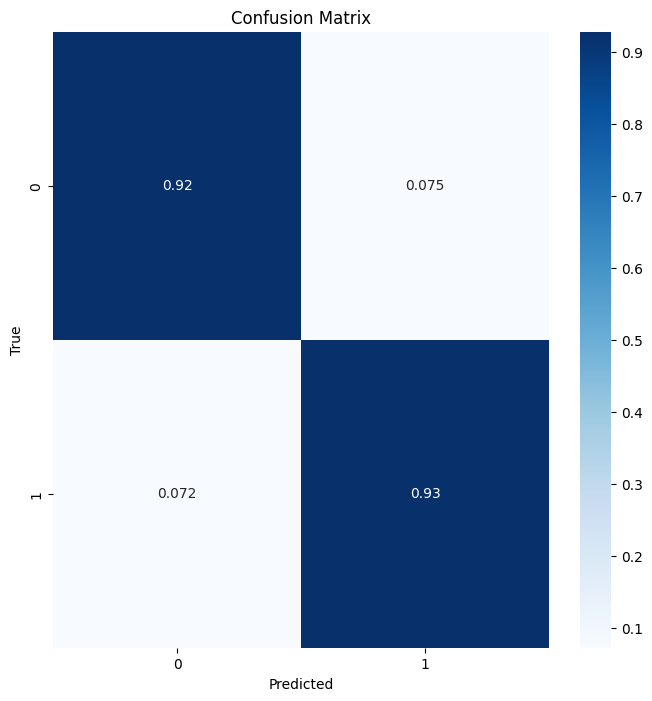

In [43]:
#confusion_matrix로 결과 확인
cm = confusion_matrix(y_test, y_pred, labels = None, sample_weight = None, normalize = 'true')

plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### confusion_matrix 분석 

1. True Negative (0.92)
- 모델이 부정 리뷰를 부정으로 정확히 예측한 비율입니다.
- 모델이 부정 리뷰를 잘 분류하고 있음을 나타냅니다.

2. False Positive (0.075)
- 모델이 부정 리뷰를 긍정으로 잘못 예측한 비율입니다.
- 7.5%의 부정 리뷰가 잘못 분류되었다는 것을 알 수 있습니다.

3. False Negative (0.072)
- 모델이 긍정 리뷰를 부정으로 잘못 예측한 비율입니다.
- 긍정 리뷰의 7.2%가 잘못 분류되었으며, 재현율이 높다는 것을 나타냅니다.

4. True Positive (0.93)
- 모델이 긍정 리뷰를 긍정으로 정확히 예측한 비율입니다.
- 긍정 리뷰의 93%가 정확하게 분류되었다는 것을 알 수 있습니다.

<br>

- 모델의 정확도는 약 92.5%로, 전반적인 성능이 매우 좋습니다.
- 정밀도는 92.5%로, 모델이 긍정 리뷰로 예측한 것 중 대부분이 실제 긍정 리뷰임을 나타냅니다.
- 재현율은 92.9%로, 모델이 실제 긍정 리뷰를 거의 모두 정확히 예측하고 있음을 보여줍니다.
- F1 점수는 92.7%로, 정밀도와 재현율의 균형을 나타내며, 모델의 전반적인 성능을 종합적으로 평가합니다.

`모델은 부정 리뷰와 긍정 리뷰 모두에서 충분히 높은 성능을 갖고 있기 때문에 성능 개선을 필요성이 낮다고 볼 수 있습니다.`

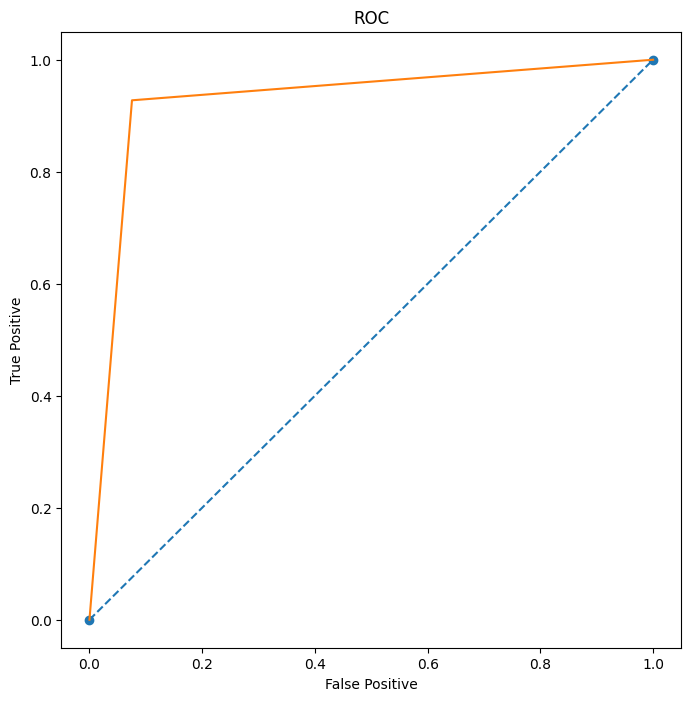

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig = plt.figure(figsize=(8, 8))

plt.plot([0, 1], [0, 1], 'o--')

plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('False Positive')
plt.ylabel('True Positive') 
plt.title('ROC') 
plt.show()

#### 분석
ROC 곡선이 대각선 기준선보다 위에 위치할수록 모델의 성능이 우수함을 나타내는데, 주황색 실선이 대각선보다 위에 있으므로, 모델이 무작위 분류기보다 성능이 좋음을 알 수 있습니다.

AUC는 1에 가까울수록 성능이 좋다는 것을 의미하는데, 0.926이라는 것을 통해 모델이 분류를 잘 한다는 것을 알 수 있습니다.

`즉, ROC 곡선과 AUC 값 모두 높은 값을 가지고 있으므로 모델의 성능이 매우 좋다는 것을 알 수 있습니다.`